# Setup

In [ ]:
# collab setup
!git clone https://github.com/kallioaa/frustration_msc.git
%cd /content/frustration_msc
import sys
from pathlib import Path

sys.path.insert(0, "/content/frustration_msc/src")

from google.colab import drive
drive.mount("/content/drive")

# google drive path 
RESULTS_PATH = Path("/content/drive/MyDrive/sweeps")


In [1]:
# local setup
import sys
from pathlib import Path

sys.path.append(str(Path.cwd().resolve().parent.parent))

# local path
# google drive path 
RESULTS_PATH = Path("outputs/sweeps/")

In [2]:
from pathlib import Path
import pickle

from experiments.sweep_plots import plot_sweep_training, plot_sweep_evaluation
from experiments.sweep_plots_helper import (
    taxi_training_plot_specs,
    taxi_evaluation_plot_specs,
    cliffwalking_training_plot_specs,
    cliffwalking_evaluation_plot_specs,
    frozenlake_training_plot_specs,
    frozenlake_evaluation_plot_specs,
)

In [3]:
# filtering for runs

from collections.abc import Iterable
from typing import Any


def _agent_kwargs(run: dict[str, Any]) -> dict[str, Any]:
    return run.get("params", {}).get("agent_kwargs", {}) or {}


# Confirmation-bias sweeps
def select_confirmatory_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_conf", float("-inf"))
        > _agent_kwargs(r).get("alpha_disconf", float("inf"))
    ]


def select_unconfirmatory_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_conf", float("inf"))
        < _agent_kwargs(r).get("alpha_disconf", float("-inf"))
    ]


def select_confirmation_baseline_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    # baseline: alpha_conf == alpha_disconf
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_conf") == _agent_kwargs(r).get("alpha_disconf")
    ]


# Positivity-bias sweeps
def select_positivity_biased_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_positive", float("-inf"))
        > _agent_kwargs(r).get("alpha_negative", float("inf"))
    ]


def select_negativity_biased_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_positive", float("inf"))
        < _agent_kwargs(r).get("alpha_negative", float("-inf"))
    ]


def select_positivity_baseline_results(
    results: Iterable[dict[str, Any]],
) -> list[dict[str, Any]]:
    # baseline: alpha_positive == alpha_negative
    return [
        r
        for r in results
        if _agent_kwargs(r).get("alpha_positive")
        == _agent_kwargs(r).get("alpha_negative")
    ]

In [22]:
from __future__ import annotations

import math
from typing import Any, Iterable


def _agent_kwargs_from_result(result: dict[str, Any]) -> dict[str, Any]:
    params = result.get("params", {}) or {}
    agent_kwargs = params.get("agent_kwargs", {}) or {}
    # Support both direct dict and {"config": {...}} style.
    if (
        isinstance(agent_kwargs, dict)
        and "config" in agent_kwargs
        and isinstance(agent_kwargs["config"], dict)
    ):
        return agent_kwargs["config"]
    return agent_kwargs


def _pair_matches(
    value_pair: tuple[float, float],
    allowed_pairs: Iterable[tuple[float, float]],
    tol: float,
) -> bool:
    a, b = value_pair
    return any(
        math.isclose(a, x, abs_tol=tol, rel_tol=0.0)
        and math.isclose(b, y, abs_tol=tol, rel_tol=0.0)
        for x, y in allowed_pairs
    )


def filter_by_ac_ad_pairs(
    results: list[dict[str, Any]],
    pairs: Iterable[tuple[float, float]],
    tol: float = 1e-9,
) -> list[dict[str, Any]]:
    pairs = list(pairs)
    if not pairs:
        return list(results)

    out: list[dict[str, Any]] = []
    for r in results:
        ak = _agent_kwargs_from_result(r)
        ac = ak.get("alpha_conf")
        ad = ak.get("alpha_disconf")
        if ac is None or ad is None:
            continue
        if _pair_matches((float(ac), float(ad)), pairs, tol):
            out.append(r)
    return out


def filter_by_ap_an_pairs(
    results: list[dict[str, Any]],
    pairs: Iterable[tuple[float, float]],
    tol: float = 1e-9,
) -> list[dict[str, Any]]:
    pairs = list(pairs)
    if not pairs:
        return list(results)

    out: list[dict[str, Any]] = []
    for r in results:
        ak = _agent_kwargs_from_result(r)
        ap = ak.get("alpha_positive")
        an = ak.get("alpha_negative")
        if ap is None or an is None:
            continue
        if _pair_matches((float(ap), float(an)), pairs, tol):
            out.append(r)
    return out


def filter_by_positivity_ratio(
    results: list[dict[str, Any]],
    ratios: Iterable[float],
    tol: float = 1e-9,
) -> list[dict[str, Any]]:
    ratios = list(ratios)
    if not ratios:
        return list(results)

    out: list[dict[str, Any]] = []
    for r in results:
        ak = _agent_kwargs_from_result(r)
        ap = ak.get("alpha_positive")
        an = ak.get("alpha_negative")
        if ap is None or an is None:
            continue

        ap = float(ap)
        an = float(an)
        if math.isclose(an, 0.0, abs_tol=tol, rel_tol=0.0):
            continue

        ratio = ap / an
        if any(
            math.isclose(ratio, target, abs_tol=tol, rel_tol=0.0) for target in ratios
        ):
            out.append(r)
    return out


def select_results(
    results: list[dict[str, Any]],
    ac_ad_pairs: Iterable[tuple[float, float]] | None = None,
    ap_an_pairs: Iterable[tuple[float, float]] | None = None,
    positivity_ratios: Iterable[float] | None = None,
    mode: str = "or",
    tol: float = 1e-9,
) -> list[dict[str, Any]]:
    """
    mode='or': keep runs matching any provided criterion
    mode='and': keep runs matching all provided criteria
    """
    if mode not in {"or", "and"}:
        raise ValueError("mode must be 'or' or 'and'")

    ac_ad_pairs = list(ac_ad_pairs or [])
    ap_an_pairs = list(ap_an_pairs or [])
    positivity_ratios = list(positivity_ratios or [])

    if not ac_ad_pairs and not ap_an_pairs and not positivity_ratios:
        return list(results)

    out: list[dict[str, Any]] = []
    for r in results:
        ak = _agent_kwargs_from_result(r)

        checks: list[bool] = []

        if ac_ad_pairs:
            ac = ak.get("alpha_conf")
            ad = ak.get("alpha_disconf")
            ok = (
                ac is not None
                and ad is not None
                and _pair_matches((float(ac), float(ad)), ac_ad_pairs, tol)
            )
            checks.append(ok)

        if ap_an_pairs:
            ap = ak.get("alpha_positive")
            an = ak.get("alpha_negative")
            ok = (
                ap is not None
                and an is not None
                and _pair_matches((float(ap), float(an)), ap_an_pairs, tol)
            )
            checks.append(ok)

        if positivity_ratios:
            ap = ak.get("alpha_positive")
            an = ak.get("alpha_negative")
            ok = False
            if ap is not None and an is not None:
                ap = float(ap)
                an = float(an)
                if not math.isclose(an, 0.0, abs_tol=tol, rel_tol=0.0):
                    ratio = ap / an
                    ok = any(
                        math.isclose(ratio, target, abs_tol=tol, rel_tol=0.0)
                        for target in positivity_ratios
                    )
            checks.append(ok)

        if any(checks) if mode == "or" else all(checks):
            out.append(r)

    return out

# Results

## Taxi V3

In [ ]:
# Taxi - confirmation bias
file_taxi_conf = RESULTS_PATH / "taxi_final_results" / "taxi_conf_all_pairs.pkl"
with file_taxi_conf.open("rb") as f:
    conf_results = pickle.load(f)
print(f"Loaded {len(conf_results)} runs from {file_taxi_conf}")

In [ ]:
plot_sweep_training(
    file_taxi_conf,
    window_size=500,
    start_episode=0,
    plot_specs=taxi_training_plot_specs(),
)

In [ ]:
plot_sweep_evaluation(results, window_size=300, plot_specs=taxi_evaluation_plot_specs())

In [ ]:
# download data for plots
# Taxi - positivity bias
file_taxi_pos = RESULTS_PATH / "taxi_final_results" / "taxi_pos_all_ratios.pkl"
with file_taxi_pos.open("rb") as f:
    pos_results = pickle.load(f)
print(f"Loaded {len(pos_results)} runs from {file_taxi_pos}")

## Cliff Walking

In [33]:
# CliffWalking  x confirmation bias
file_cliffwalking_conf = RESULTS_PATH / "cliffwalking_final_results" / "cliffwalking_conf_all_pairs.pkl"

with file_cliffwalking_conf.open("rb") as f:
    conf_results = pickle.load(f)
print(f"Loaded {len(conf_results)} runs from {file_cliffwalking_conf}")

# CliffWalking  x confirmation bias
file_cliffwalking_pos = (
    RESULTS_PATH / "cliffwalking_final_results" / "cliffwalking_pos_all_ratios.pkl"
)

with file_cliffwalking_pos.open("rb") as f:
    pos_results = pickle.load(f)
print(f"Loaded {len(pos_results)} runs from {file_cliffwalking_pos}")

cliffwalking_results = conf_results + pos_results

Loaded 165 runs from outputs/sweeps/cliffwalking_final_results/cliffwalking_conf_all_pairs.pkl
Loaded 90 runs from outputs/sweeps/cliffwalking_final_results/cliffwalking_pos_all_ratios.pkl


In [34]:
conf_conf_results = select_confirmatory_results(conf_results) + select_confirmation_baseline_results(conf_results)
conf_disconf_results = select_unconfirmatory_results(conf_results) + select_confirmation_baseline_results(conf_results)

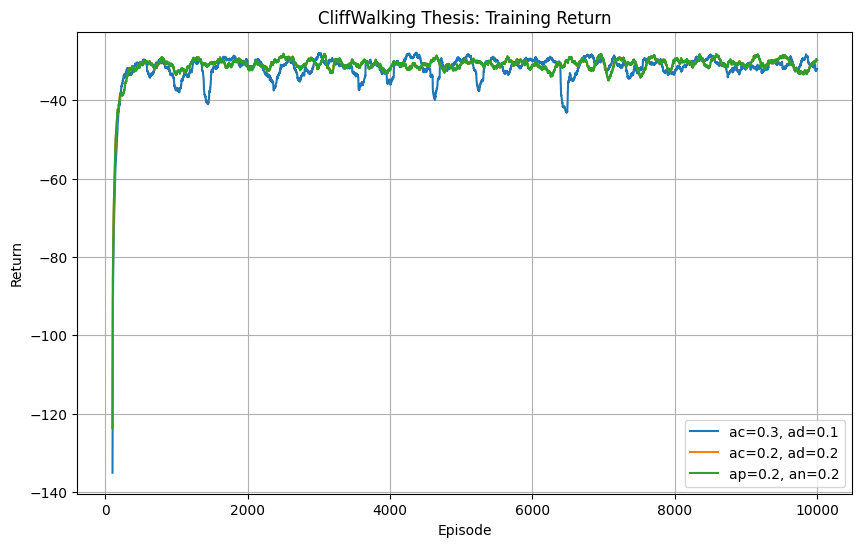

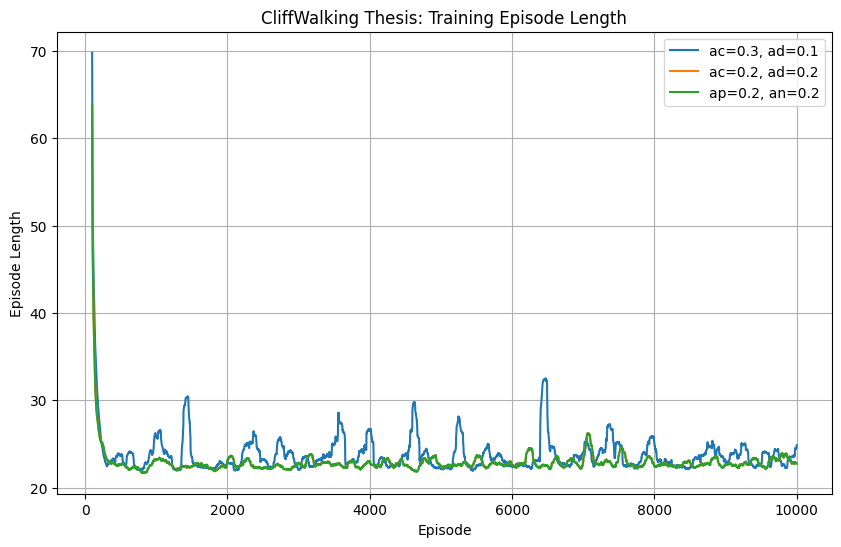

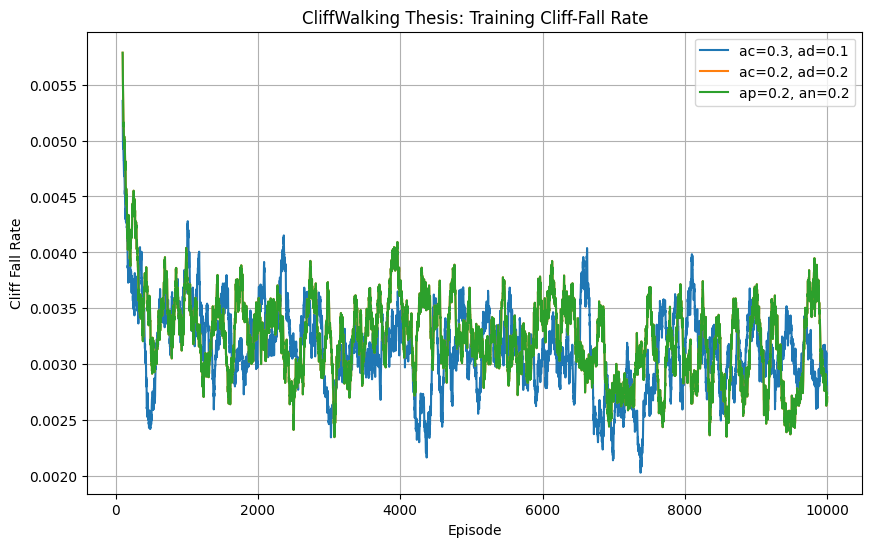

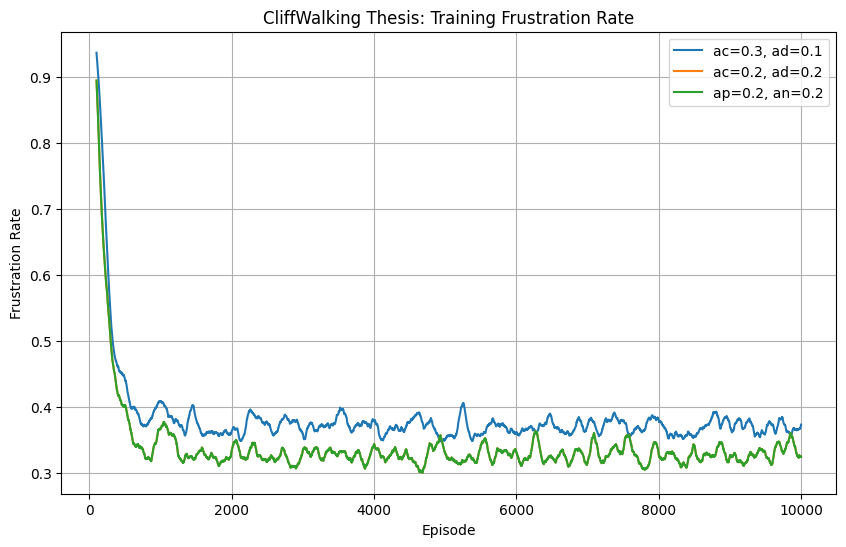

In [40]:
import importlib

from experiments.sweep_plots import plot_sweep_training
import experiments.sweep_plots_helper_thesis as thesis_cfg_mod

importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.cliffwalking_training_thesis_config()

subset = select_results(
    cliffwalking_results,
    ac_ad_pairs=[(0.3, 0.1), (0.2, 0.2)],
    positivity_ratios=[1.0],
    mode="or",
)

plot_sweep_training(
    subset,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
    use_td_error_v=cfg["use_td_error_v"],
)

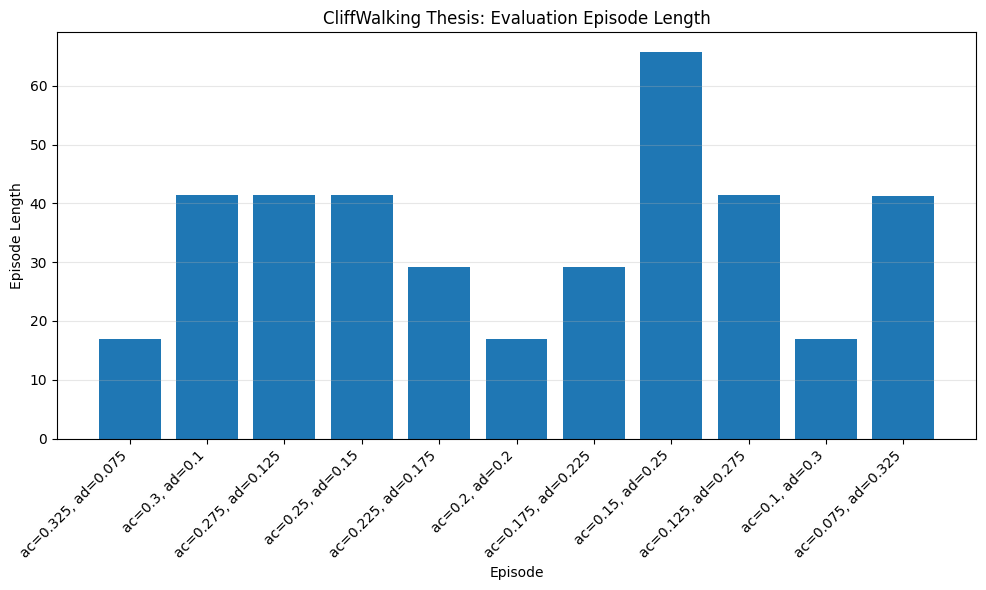

In [14]:
import importlib

from experiments.sweep_plots import plot_sweep_evaluation
import experiments.sweep_plots_helper_thesis as thesis_cfg_mod

importlib.reload(thesis_cfg_mod)

cfg = thesis_cfg_mod.cliffwalking_evaluation_thesis_config()

plot_sweep_evaluation(
    conf_results,
    window_size=cfg["window_size"],
    label_fn=cfg["label_fn"],
    plot_specs=cfg["plot_specs"],
    start_episode=cfg["start_episode"],
    end_episode=cfg["end_episode"],
)

In [ ]:
# CliffWalking - positivity bias
file_cliffwalking_pos = RESULTS_PATH / "cliffwalking_final_results" / "cliffwalking_pos_all_ratios.pkl"
with file_cliffwalking_pos.open("rb") as f:
    pos_results = pickle.load(f)
print(f"Loaded {len(pos_results)} runs from {file_cliffwalking_pos}")

## Frozen Lake

In [ ]:
# FrozenLake - confirmation bias
file_frozenlake_conf = Path("outputs/sweeps/frozenlake_final_results/frozenlake_conf_all_pairs.pkl")
with file_frozenlake_conf.open("rb") as f:
    conf_results = pickle.load(f)
print(f"Loaded {len(conf_results)} runs from {file_frozenlake_conf}")

In [ ]:
plot_sweep_training(
    cliffwalking_evaluation_plot_specs,
    window_size=500,
    start_episode=0,
)

In [ ]:
# FrozenLake - positivity bias
file_frozenlake_pos = Path("outputs/sweeps/frozenlake_final_results/frozenlake_pos_all_ratios.pkl")
with file_frozenlake_pos.open("rb") as f:
    pos_results = pickle.load(f)
print(f"Loaded {len(pos_results)} runs from {file_frozenlake_pos}")